#Set Up

##Initializing Notebook

In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import string
import math
from ast import literal_eval
import json
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mp
import matplotlib.pyplot as plt
mp.use('Agg', warn=False)
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 20)
import plotly.plotly as py
py.sign_in('00schen', 'KDzD3KwYEL8yey6ZwRLP')
rgb_coor = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48), (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 190), (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
rgb = ['rgb'+str(color) for color in rgb_coor]

#edit the path of data, number of files to analyze, and density of success rate
DRIVE = True
KICKSTARTER_LOCATION = '/content/gdrive/My Drive/rawdata'
NUM_FILES = 50
BIN_SPLITS = 20

In [0]:
#only if using drive
if DRIVE:
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Main Dataframe Construction

Then we load our datasets from https://webrobots.io/kickstarter-datasets/, a web crawler.
We used data up to 2018/09/13.

In [0]:
#add relevant data to Kickstarter dataframe
def construct(df, variables):
  df, errors = df.copy(deep=True), []
  for i in range(NUM_FILES):
    file = '{0}/Kickstarter{1}.csv'.format(KICKSTARTER_LOCATION, fix_digits(i+1))
    try:
      part = pd.read_csv(file)
    except:
      errors.append(i)
      pass
    df = df.append(part)
  print('failed file reads: {0}'.format(errors))
  df = apply(df, variables)
  return df

#sequence file names
def fix_digits(n):
  zeroes = 2 - int(math.log10(n))
  return zeroes*'0'+str(n) if n != 0 else None

In [0]:
#Protocol: SEAVE out relevant columns and ADD CATEGORY labels to data
def apply(df, variables):
  df = df.copy(deep=True)
  df = seave(df, variables)
  df = add_cat(df)
  return df

#fix abstraction
#filter relevant information
def seave(df, variables):
  df = df.copy(deep=True)
  df = df[variables + ['state','category']]
  df = df[df.state != 'live']
  return df

#add category names as new column
def add_cat(df):
  df = df.copy(deep=True)
  df['slug'] = df['category'].map(lambda s: eval(s)['slug'])
  df['cats'] = df['slug'].map(seperate)
  df['big_cat'], df['small_cat'] =\
  df['cats'].map(lambda s: s[0]), df['cats'].map(lambda s: s[1])
  df = df.drop(['category', 'slug', 'cats'], axis=1)
  return df

#extract category information from slug
def seperate(category):
  if '/' in category:
    dash = category.index('/')
    return category[:dash], category[dash+1:]
  return category, []

In [0]:
variables = ['goal', 'launched_at', 'deadline', 'backers_count', 'staff_pick',\
             'spotlight', 'location', 'name', 'blurb', 'converted_pledged_amount']
Kickstarter = pd.DataFrame()
Kickstarter = construct(Kickstarter, variables)

failed file reads: []


##General Functions

In [0]:
#splits column into bins and calculates conditional probability of success in each bin
def dv(df, bin_col=None, bin_splits=BIN_SPLITS):
  df = df.copy(deep=True)
  
  #creating bin
  if df[bin_col].dtype in [np.int64, np.float64]:
    label = [pd.cut(df[bin_col], bins = bin_splits, right = True, include_lowest = True)]
  elif bin_col == 'big_cat':
    label = []
  else:
    label = [bin_col]
  
  #The total conditional outcome space and success space are calculated
  count =df.groupby(['big_cat', 'state']+label).size().to_frame(name='num').reset_index()
  totals =df.groupby(['big_cat']+label).size().to_frame(name='denom').reset_index()
  count = pd.merge(count, totals, on=['big_cat', bin_col], how = 'outer')
  
  #proportion is calculated
  count.sort_values(by=['big_cat','state',bin_col], inplace=True)
  count['proportion'] = count['num']/count['denom']
  count = count[count['state']=='successful']
  
  count = count.drop('state', axis=1)
  if df[bin_col].dtype in [np.int64, np.float64]:
    count[bin_col] = count[bin_col].apply(lambda x: x.right)
    count[bin_col] = count[bin_col].astype('int64')
  return count

def log(df, bin_cat):
  df = df.copy(deep=True)
  df[bin_cat] = df[bin_cat].apply(np.log)
  return df

In [0]:
def set_labels(fig, title, x, y):
  fig.set_title(title,fontsize = 20*1.5)
  fig.set_xlabel(x, fontsize = 15*1.5)
  fig.set_ylabel (y, fontsize = 15*1.5)
  return fig

# 1. Duration vs. Success

In this part, we are looking at a campaign's **duration** (we define duration by the period between moment the creator launched the project and their final deadline.) and whether they are successful or not to determine if there's some sort of correlation between them.

## Clearing data

Below we cleared the data to contain only the project launch date, deadline, and their state of success or failure. We are also not looking at projects that are still live, suspended, or cancelled. Also, the dates in the raw dataset are expressed in epoch time; we convert them into readable times.

In [0]:
category = 'technology'

deadline = Kickstarter[['big_cat', 'deadline', 'launched_at', 'state']]
deadline['deadline'] = pd.to_datetime(deadline['deadline'], unit='s')
deadline['launched_at'] = pd.to_datetime(deadline['launched_at'], unit='s')
deadline['duration'] = deadline['deadline'].sub(deadline['launched_at']).dt.days
deadline = deadline[deadline['big_cat'] == category]
deadline['state'] = deadline['state'].map(\
lambda s: 'successful' if s == 'successful' else 'failed')

In [0]:
scatter_df = log(deadline, 'duration')
scatter_df = dv(scatter_df, 'duration', 20)

##Data Visualization
We now visualize the data in various ways to visually determine if there's any correlation.


### Boxplot

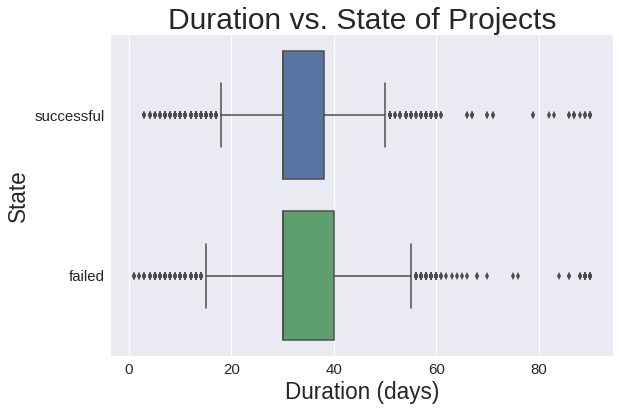

In [0]:
fig1 = sns.boxplot(x='duration',y='state',data=deadline,linewidth=1.5)
fig1 = set_labels(fig1, "Duration vs. State of Projects", "Duration (days)", "State")
fig1.tick_params(labelsize = 15)

###Histogram

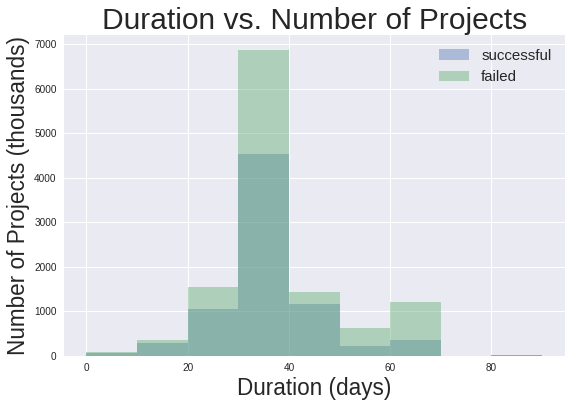

In [0]:
for state in ['successful','failed']:
    fig2 = sns.distplot(deadline.loc[deadline['state']==state,'duration'], kde=False, bins=[10*i for i in range(10)], label=state)
    
fig2 = set_labels(fig2, "Duration vs. Number of Projects", "Duration (days)", "Number of Projects (thousands)")
plt.legend(fontsize = 15)
plt.show()

###Scatterplot

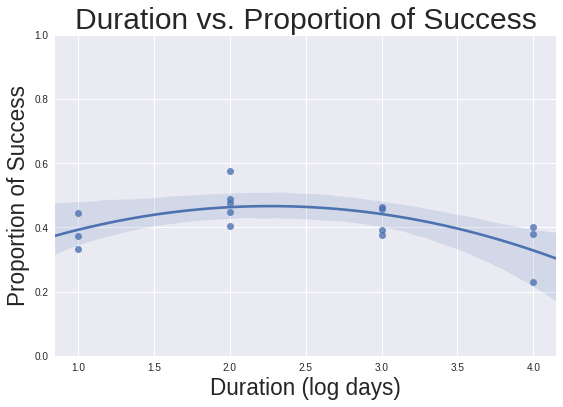

In [0]:
fig3 = sns.regplot(x='duration', y='proportion', data=scatter_df, order=2)
fig3 = set_labels(fig3, "Duration vs. Proportion of Success", "Duration (log days)", "Proportion of Success")
plt.ylim(0,1)
plt.show()

#2. Staff pick

In [0]:
feature = Kickstarter[['big_cat', 'staff_pick', 'state']]
staff_pick = dv(feature, 'staff_pick')
staff_pick = staff_pick.sort_values('proportion')

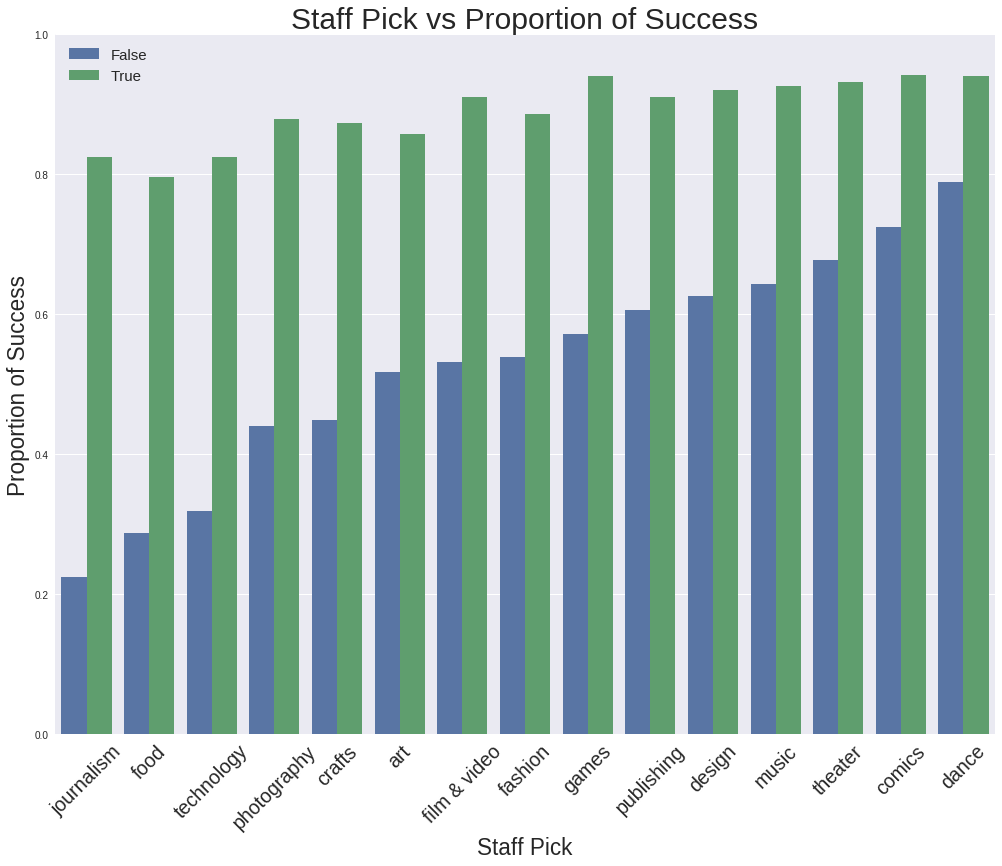

In [0]:
plt.figure(figsize=(15,12))
fig = sns.barplot(x='big_cat', y='proportion', hue= 'staff_pick', data=staff_pick)
fig = set_labels(fig, "Staff Pick vs Proportion of Success", 'Staff Pick', 'Proportion of Success')
plt.xticks(rotation = 45, fontsize = 13*1.5)
plt.ylim(0, 1)
plt.legend(fontsize = 15)
plt.show()

#3. Goal Amount

In [0]:
category = 'technology'
goal_amount = Kickstarter[['big_cat', 'goal', 'state']]
goal_amount = goal_amount[goal_amount['big_cat'] == category]
goal_amount = log(goal_amount, 'goal')
goal_amount = dv(goal_amount, 'goal', 40)

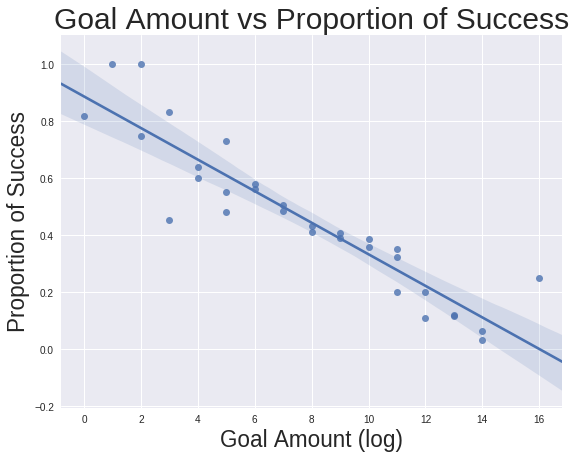

In [0]:
plt.figure(figsize = (8, 6.4))
fig = sns.regplot(x='goal', y='proportion', data=goal_amount)
fig = set_labels(fig, "Goal Amount vs Proportion of Success", "Goal Amount (log)", 'Proportion of Success')
plt.show()

#4. Category

##Data Clearing

In [0]:
category = Kickstarter[['big_cat', 'state', 'backers_count', 'converted_pledged_amount']]

In [0]:
back_pledge = category[['backers_count','big_cat','converted_pledged_amount']]
back_pledge = back_pledge.groupby(['big_cat']).sum().reset_index()
back_pledge['average_pledge'] = (back_pledge['converted_pledged_amount'] / back_pledge['backers_count']).round()
back_pledge['converted_pledged_amount'] = back_pledge['converted_pledged_amount'].map(lambda x: x/1e6)
back_pledge['backers_count'] = back_pledge['backers_count'].map(lambda x: x/1e6)
cat_prop = dv(category, 'big_cat')

sorted_total= back_pledge.sort_values('converted_pledged_amount', ascending= False)
sorted_avg=back_pledge.sort_values('average_pledge', ascending= False)
sorted_backers = back_pledge.sort_values('backers_count', ascending = False)
cat_prop = category_prop.sort_values('proportion', ascending = False)

In [0]:
def category_bar(df, ycol, title, ylabel):
  plt.figure(figsize=(15,12))
  s1 = sns.barplot(x='big_cat', y=ycol, data= df, color = "dodgerblue"); #"dodgerblue"
  s1.set_title('Total Pledge Amount Vs. Category',fontsize = 20*1.5)
  s1.set_xlabel('Category', fontsize = 15*1.5)
  s1.set_ylabel (ylabel, fontsize = 15*1.5)
  if ycol == 'proportion':
    plt.ylim(0,1)
  plt.xticks(rotation = 45, fontsize = 13*1.5)
  plt.show()

##Data Visualizations

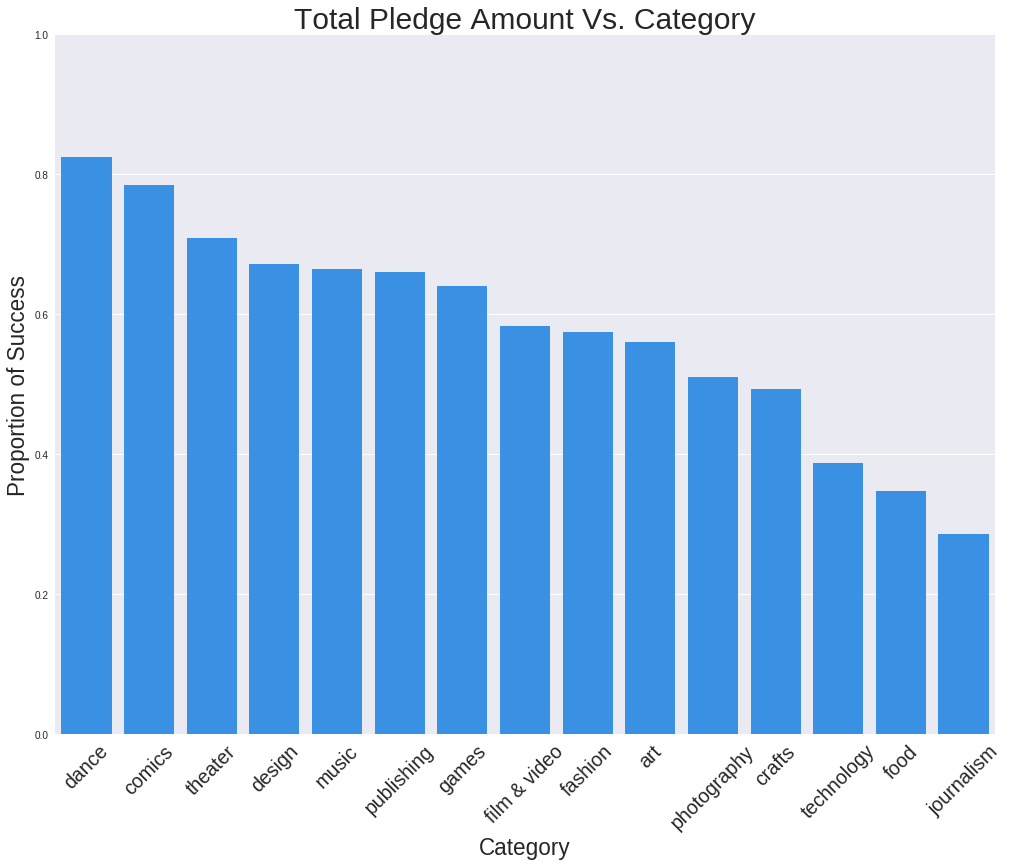

In [0]:
category_bar(cat_prop, 'proportion', "Success Rate of Each Category", "Proportion of Success")

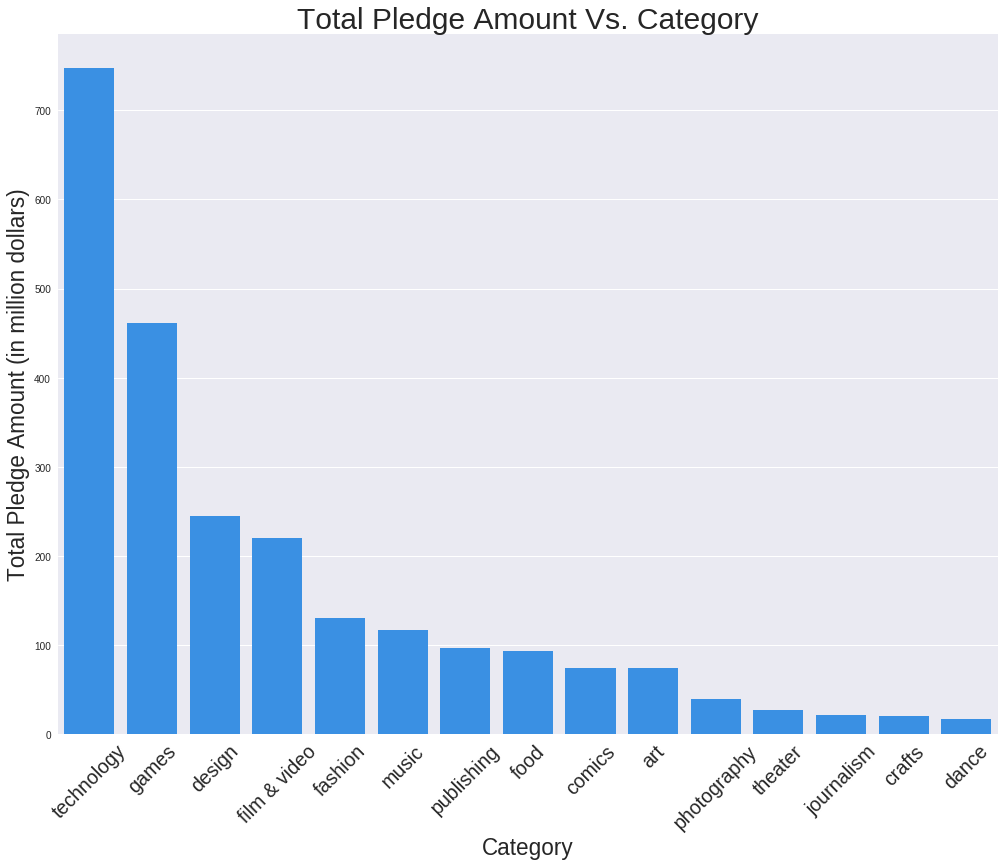

In [0]:
category_bar(sorted_total, 'converted_pledged_amount', "Total Pledge Amount Vs. Category", "Total Pledge Amount (in million dollars)")

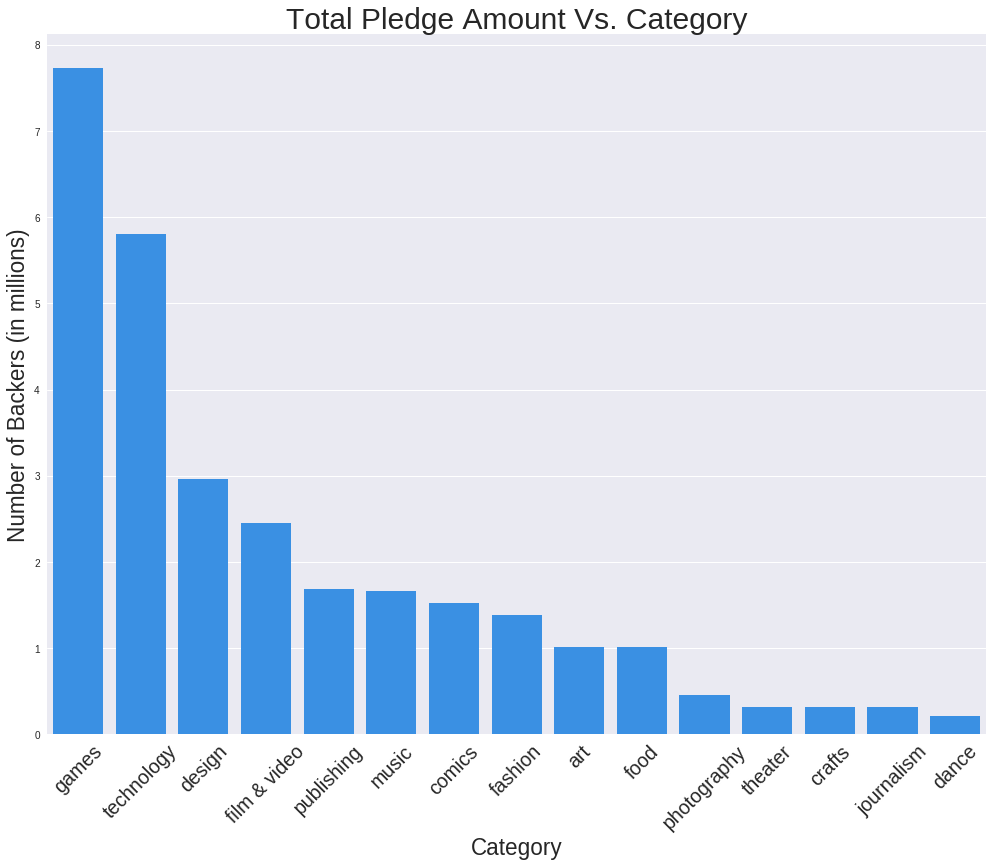

In [0]:
category_bar(sorted_backers, 'backers_count', "Number of Backers Vs. Category", "Number of Backers (in millions)")

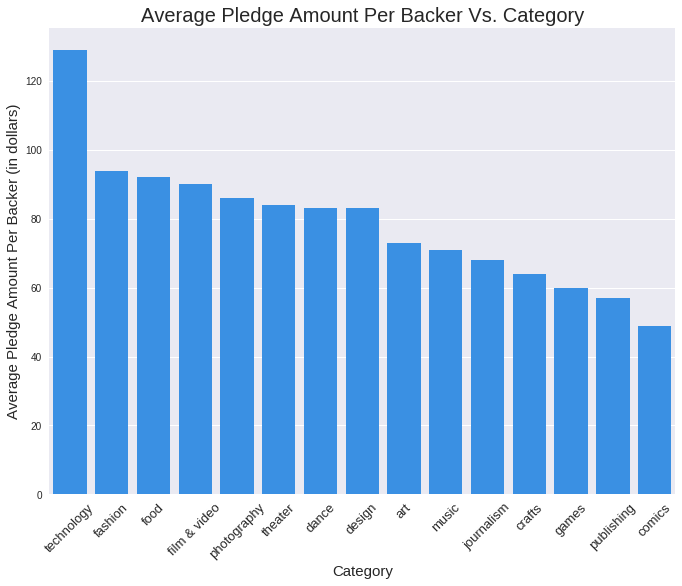

In [0]:
plt.figure(figsize=(10,8))
s1 = sns.barplot(x='big_cat', y='average_pledge', data=sorted_avg, color = "dodgerblue");
s1.set_title('Average Pledge Amount Per Backer Vs. Category',fontsize = 20)
s1.set_xlabel('Category', fontsize = 15)
s1.set_ylabel ('Average Pledge Amount Per Backer (in dollars)', fontsize = 15)
plt.xticks(rotation = 45, fontsize = 13)
plt.show()

#5. Location

##Data Clearing and Plotting

In [0]:
#extract location information from dictionary
def location_names(df):
  df = df.copy(deep=True)
  df = df[df['location'].notnull()].reset_index(drop=True)
  df['location'] = df['location'].str.replace('true',"True")
  df['location'] = df['location'].str.replace('false','False')
  df['location'] = df['location'].str.replace('null','None')
  df['location'] = df['location'].map(literal_eval)
  df['country'] = df['location'].map(lambda s: s['country'])
  df['province'] = df['location'].map(lambda s: s['state'])
  df['city'] = df['location'].map(lambda s: s['localized_name'])
  df['short_name'] = df['location'].map(lambda s: s['short_name'])
  df = df.drop(['location'], axis=1)
  return df

def load_coordinates(df):
  with open('{0}/new_geocoded_dict.json'.format(KICKSTARTER_LOCATION), 'r') as fp:
    geo_dict = json.load(fp)
  df = df.copy(deep=True) 
  df['coordinates'] = df['short_name'].map(geo_dict)
  df = df.dropna()
  df['lon'] = df['coordinates'].map(lambda s: s[1])
  df['lat'] = df['coordinates'].map(lambda s: s[0])
  df.drop('coordinates', axis=1)
  return df

#given location is extracted, sort for analysis
def location_sort(df):
  df = df.copy(deep=True)
  df=df.groupby(['big_cat', 'short_name']).size().to_frame(name='count').reset_index()
  return df

In [0]:
def compile_count_df(df):
  loc_sort = df.copy(deep=True)
  loc_sort = location_names(Kickstarter)
  loc_sort = loc_sort[loc_sort['country']=='US']
  loc_sort = location_sort(loc_sort)
  loc_sort = load_coordinates(loc_sort)
  return loc_sort

def compile_prop_sort(df):
  loc_df = df.copy(deep=True)
  loc_df = location_names(Kickstarter)
  loc_df = loc_df[loc_df['country']=='US']
  loc_df = dv(loc_df, 'short_name')
  loc_df = load_coordinates(loc_df)
  loc_df = loc_df[loc_df['denom'] > 30]
  return loc_df

In [0]:
def count_bubble_sort(df, cat=None):
  df = df.copy(deep=True)
  df = df[df['count']>50]
  df['text'] = df['short_name'] + '<br>count ' + (df['count']).astype(str) #loc_sort is my file with coordinates loaded in
  if isinstance(cat, str):
    categories = [cat]
  elif isinstance(cat, list):
    categories = cat
  else:
    categories = df['big_cat'].unique().tolist() #big_cat is category names
  colors = rgb
  cities = []
  scale = 70

  for i in range(len(categories)):
      cat = categories[i]
      df_sub = df[df['big_cat']==cat]
#       df_sub = df[df['count']>100]
      city = dict(
          type = 'scattergeo',
          locationmode = 'USA-states',
          lon = df_sub['lon'],
          lat = df_sub['lat'],
          text = df_sub['text'],
          marker = dict(
              size = df_sub['count']/scale,
              sizeref = 2. * max(df_sub['count']/scale) / (40 ** 2),
              color = colors[i],
              line = dict(width=0.5, color='rgb(40,40,40)'),
              sizemode = 'area'
          ),
          name = cat )
      cities.append(city)

  layout = dict(
          title = 'Category Counts By City',
          showlegend = True,
          legend = dict(
              x=0,
              y=1,
              traceorder='normal',
              font=dict(
                  family='sans-serif',
                  size=20,
                  color='#000'
              ),
              bgcolor='#E2E2E2',
              bordercolor='#FFFFFF',
              borderwidth=2
            ),
          geo = dict(
              scope='usa',
              projection=dict( type='albers usa' ),
              showland = True,
              landcolor = 'rgb(217, 217, 217)',
              subunitwidth=1,
              countrywidth=1,
              subunitcolor="rgb(255, 255, 255)",
              countrycolor="rgb(255, 255, 255)"
          )
      )

  fig = dict(data=cities, layout=layout)
  return py.iplot(fig, validate=False, filename='Category_Counts_by_City')

In [0]:
largest = 10
location = Kickstarter[['big_cat', 'state', 'location']]
location = location_names(location)
location = location_sort(location)
categories = location['big_cat'].unique()
for cat in categories:
  sub = location[location['big_cat']==cat]
  center = sub.nlargest(largest, 'count')

##Data Visualization

###Category Counts By City

In [0]:
loc_sort = compile_count_df(Kickstarter)
count_bubble_sort(loc_sort)

HTTPError: ignored

In [0]:
count_bubble_sort(loc_sort, 'technology')

##Geocoding
  only uncomment if processing data

In [0]:
# #imports for geocoding

# !pip install geopy
# #Only for Geocoding
# import geopy.geocoders as geo
# from geopy.geocoders import Nominatim, Yandex
# from geopy.extra.rate_limiter import RateLimiter

In [0]:
# #dictionary of unique location names
# geodic = location_names(Kickstarter)
# geodic = geodic['short_name'].unique()
# geodic = pd.DataFrame({'short_name':geodic})
# #Adjust amount of pieces according to size of dictionary, specifically size/1000
# print(geodic['short_name'].size)

In [0]:
# PIECES = 15
# #Use Yandex instead of Nominatim
# def make_geocode(df, geocoder):
#   """Depending on geocoders used, geocoder constructors will change"""
#   df = df.copy(deep=True)
#   geo.options.default_timeout = 1
#   if geocoder is Nominatim:
#     geolocator = geocoder(user_agent='Kickstarter')
#   elif geocoder is Yandex:
#     geolocator = geocoder(user_agent='Kickstarter')
#   geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
#   df['coordinates'] = df['short_name'].apply(geocode)
#   df['coordinates'] = df['coordinates'].apply(\
#   lambda col: (col.latitude, col.longitude) if col else None)
#   return df

# def backup_geocode(geocoded, piece_number):
#   geocoded.to_json('{0}/geocoded_{1}.json'.format(KICKSTARTER_LOCATION, piece_number))
  
# def compile_geocode(read_min = 0, read_max = PIECES):
#   geo_dict = pd.DataFrame(columns = ['coordinates', 'short_name'])
#   for piece_number in range(read_min, read_max):
#     df = pd.read_json('{0}/geocoded_{1}.json'.format(KICKSTARTER_LOCATION, piece_number))
#     geo_dict = pd.concat([geo_dict, df])
#   return geo_dict

# def catch_geocode(df):
#   """Use a different geocoder to retry missed locations"""
#   #seave for missing data
#   df = df.copy(deep=True)
#   complete = df.dropna()
#   missing = df[df.isnull().any(axis=1)]

#   #apply geocoding
#   missing = make_geocode(missing, Yandex)
  
#   #make backup of geocode
#   backup_geocode(missing, 'missing')
  
#   #new data filled in
#   df = pd.concat([complete, missing])
#   return df

# def commit_geocode(geocoded):
#   geocoded.to_json('{0}/geocoded_df.json'.format(KICKSTARTER_LOCATION))

In [0]:
# geocode_df = location_names(Kickstarter)
# geocode_df = geocode_df[geocode_df['province']=='CA']
# geocode_df['short_name'] = geocode_df['short_name'].str.replace('CA', 'California')


In [0]:
# geocode_df = geocode_df['short_name'].unique()
# geocode_df = pd.DataFrame({'short_name':geocode_df})

In [0]:
# piece = make_geocode(geocode_df, Yandex)
# backup_geocode(geocode_df, 'Cal')

In [0]:
# backup_geocode(piece, 'Cal')

In [0]:
# cal_coor = pd.read_json('{0}/geocoded_{1}.json'.format(KICKSTARTER_LOCATION, 'Cal'))
# cal_coor['short_name'] = cal_coor['short_name'].str.replace('California', 'CA')
# cal_coor = cal_coor[['short_name', 'coordinates']]
# cal_coor = cal_coor.set_index('short_name').to_dict()['coordinates']

In [0]:
# print(cal_coor)

In [0]:
# geodic = location_names(Kickstarter)
# caldic = geodic[geodic['province']=='CA']
# geodic = geodic[geodic['province']!='CA']
# geodic = load_coordinates(geodic)

In [0]:
# cal_coor = cal_coor.to_dict

In [0]:
# geo_dict, df = cal_coor, caldic
# df['coordinates'] = df['short_name'].map(geo_dict)

In [0]:
# with open('{0}/geocoded_dict.json'.format(KICKSTARTER_LOCATION), 'r') as fp:
#     dict = json.load(fp)
# geodic['coordinates'] = geodic['short_name'].map(dict)

In [0]:
# geodic = pd.concat([geodic, df])

In [0]:
# geodic = geodic[['short_name', 'coordinates']]

In [0]:
# geodic = geodic.drop_duplicates(subset='short_name')

In [0]:
# geogeodic.set_index('short_name').to_dict()['coordinates']


In [0]:
# with open('{0}/new_geocoded_dict.json'.format(KICKSTARTER_LOCATION), 'w') as fp:
#     json.dump(geodic, fp)

In [0]:
# geodic = location_names(Kickstarter)
# caldic = geodic[geodic['province']=='CA']
# geodic = geodic[geodic['province']!='CA']

In [0]:
# #break dictionary into pieces
# pieced_geodic = []
# for i in range(0, PIECES*1000, 1000):
#   pieced_geodic.append(geodic.iloc[i:(i+1000)])
  
# #sequentially geocode pieces of data and make backups
# for piece_number in range(0, PIECES):
#   piece = pieced_geodic[piece_number].copy(deep=True)
#   piece = make_geocode(piece, Yandex)
#   backup_geocode(piece, piece_number)
  
# #assemble the geocoded pieces and retry the missing data
# geo_dict = compile_geocode(0, PIECES)
# geo_dict = catch_geocode(geo_dict)
# commit_geocode(geo_dict)

In [0]:
# geo_dict = pd.read_json('{0}/geocoded_dict.json'.format(KICKSTARTER_LOCATION))
# geo_dict['latitude'] = geo_dict['coordinates'].map(lambda s: s[0] if s else None)
# geo_dict['longitude'] = geo_dict['coordinates'].map(lambda s: s[1] if s else None)
# geo_dict = geo_dict.drop('coordinates', axis = 1)
# geo_dict = geo_dict.set_index('short_name').T.to_dict('list')

In [0]:
# with open('{0}/geocoded_dict.json'.format(KICKSTARTER_LOCATION), 'w') as fp:
#     json.dump(geo_dict, fp)

#6. Title and Blurb

##Data Clearing

In [0]:
category = 'technology'

def count_words(df, col):
  df = df.copy(deep=True)
  df[col] = df[col].astype(str)
  df['{0}_length'.format(col)] = df[col].str.count(' ')
  return df

def count_length(df, col, max_len, bin_split=BIN_SPLITS):
  df = df.copy(deep=True)
  length = '{0}_length'.format(col)
  df = df[df[length] < max_len]
  label = [pd.cut(df[length], bins = 20, right = True, include_lowest = True)]
  df = df.groupby(label).size().to_frame(name='num').reset_index()
  df[length] = df[length].apply(lambda x: x.right)
  df[length] = df[length].astype('int64')
  return df

In [0]:
names = Kickstarter[['big_cat', 'state', 'name', 'blurb']]
names = names[names['big_cat']==category]

In [0]:
title = names[['big_cat', 'state', 'name']]
title = title.rename(columns={'name':'title'})
title = count_words(title, 'title')
title_prop = dv(title, 'title_length', 20)

In [0]:
blurb = names[['big_cat', 'state', 'blurb']]
blurb = count_words(blurb, 'blurb')
blurb = blurb[blurb['blurb_length']<40]
blurb_prop = dv(blurb, 'blurb_length', 20)

##Data Visualization

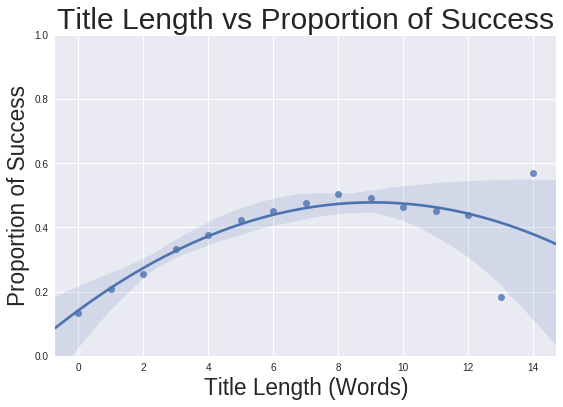

In [0]:
fig1 = sns.regplot(x='title_length', y='proportion', data=title_prop, order=2)
fig1 = set_labels(fig1, "Title Length vs Proportion of Success", "Title Length (Words)", 'Proportion of Success')
plt.ylim(0,1)
plt.show()

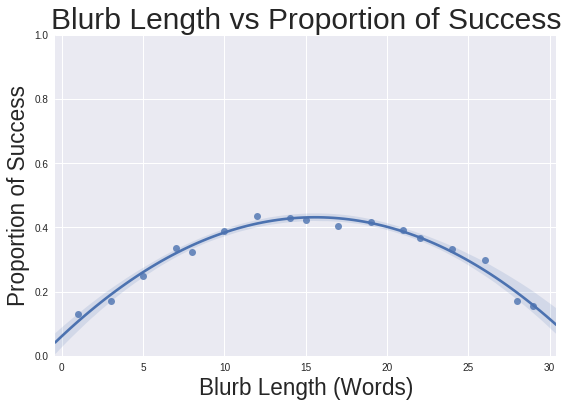

In [0]:
fig4 = sns.regplot(x='blurb_length', y='proportion', data=blurb_prop, order=2)
fig4 = set_labels(fig4, "Blurb Length vs Proportion of Success", "Blurb Length (Words)", 'Proportion of Success')
plt.ylim(0,1)
plt.show()